In [1]:
### Aufrufen der erforderlicher Programmbibliothken

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
### Funktion zum Laden von Bildern in Graustufen aus unterschiedlichen Ordnern

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), 0)
        if img is not None:
            images.append(img)
    return images

In [3]:
path_gewebe = r'C:\Users\FabianNolte\OneDrive - rwth-aachen.de\Bachelorarbeit\Fotos DeltaT\27.10. ITA\DK_perfekt'
path_alu = r'C:\Users\FabianNolte\OneDrive - rwth-aachen.de\Bachelorarbeit\Fotos DeltaT\27.10. ITA\Alu\DK_perfekt'
path_test = r'C:\Users\FabianNolte\OneDrive - rwth-aachen.de\Bachelorarbeit\Fotos DeltaT\20.10. ITA\DK_perfekt'
pathes = [path_gewebe, path_alu, path_test]

images = []
for path in pathes: 
    images_temp = load_images_from_folder(path)
    images_temp = np.asarray(images_temp)
    
    for i in range(images_temp.shape[0]):
        images.append(images_temp[i])
        
img_g1 = images[0]
img_g2 = images[1]
img_a1 = images[2]
img_a2 = images[3]
test_set = images[4:]

In [ ]:
### Funktion zur Identifikation der Bauteilseite

def identifier(image):
    height = image.shape[0]
    width = image.shape[1]
    
    # Definition eines 3x3 Mittelwertfilters
    temp_list = []
    for i in range(1,4):
        for j in range(1,4):
            temp_list.append(image[int(height/2 - i + 2)][int(width/2 - j +2)])
    mean = sum(temp_list) / len(temp_list)
    
    # Entscheidung über die Bauteilseite anhand des gemittelten Helligkeitswertes
    if mean <= 120:
        surface = 0  # Wert 0 indiziert die Gewebeseite
    else:
        surface = 1  # Wert 1 beschreibt die Aluminiumseite
    
    return surface       

In [5]:
### Detektion der Druckknöpfe

def get_snaps(image):
    # Bildvorverarbeitung durch Median-Filter
    median = cv2.medianBlur(image,5)
    # Erkennen der kreisförmigen Druckknöpfe mit dem Hough Circle Algorithmus und speichern in einer Liste
    circles = cv2.HoughCircles(median, 
                               cv2.HOUGH_GRADIENT, 1, 
                               minDist =100, # minimale Distanz zwischen Kreisen
                               param1=120, param2=35, 
                               minRadius=21,
                               maxRadius=44) 
    if circles is not None: # Prüfen, ob der ALgorithmus Druckknöpfe gefunden hat
        circles = circles.reshape(-1,3) # Liste mit den detektierten Druckknöppfe in der Form (x, y, r)
    # Extrahierung der einzelnen Druckknopfbilder in 100x100 Pixel
    SEGMENT_SIZE = 50 # Halbe Höhe und Breite der extrahierten Druckknopfbilder    
    detected_circles = np.uint16(np.around(circles)).reshape(-1,3) # Runden von (x, y, r) in ganzzahlige Werte
    snap_images = []
    for i in detected_circles:
        x = i[0] # x-Wert der Druckknopfes
        y = i[1] # y-Wert der Druckknopfes
        height = image.shape[0] # Bilhöhe
        width = image.shape[1] # Bildbreite
        snap = image[y-SEGMENT_SIZE: y+SEGMENT_SIZE, x-SEGMENT_SIZE : x+SEGMENT_SIZE]
        snap_images.append(snap)    
    # Liste mit der Druckknopfknöpfen
    snap_images = np.uint16(np.around(snap_images))  
    return circles, snap_images 
### Die Funktion hat zwei Outputs: Die Liste der Druckknopfkoordinaten (x, y, r) und eine Liste der
### 100x100 Pixel großen Druckknopfbilder


In [36]:
### Funktion zur Bauteilausrichtung
### Import muss ein Bauteilbild in Graustufen sein
def deskew(image):    
    
    # Funktion zum Begrenzen des Bauteils mit einem minimalen Rechteck (Framing)
    def get_rectangle(image):
        # Vorverarbeitung durch Glättungsfilter und Schwellwertverfahren
        median = cv2.medianBlur(image, 5)
        thresh=cv2.threshold(median,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # Otsu-Verfahren
        # Bestimmung der Konturen
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE ,cv2.CHAIN_APPROX_SIMPLE)

        # Auffinden der bauteilzugehörigen Kontur
        cnt1 = 0
        for i,contour in enumerate(contours):
            temp_len = cv2.arcLength(contour, closed = -1)
  
            if temp_len > 6500 and temp_len < 9000:

                cnt1 = contour
                idx1 = i
                break
            else:
                continue
        # Rechteckbestimmung mit Bauteilkontur
        rect = cv2.minAreaRect(cnt1) # [(Koordinaten der oberen linken Ecke des Rechtecks, Breite und Höhe, Winkel)]
        box_angle = rect[-1] 
        center=np.array(rect[1]) # Entspricht der maximalen Bautelänge- und höhe.
        corner = rect[0] # obere linke Ecke des Rechtecks
        box2d = cv2.boxPoints(rect) # Konvertierung in vier Rechteckpunkte
        box2d = np.int0(box2d) 
        return box2d, box_angle, center # Rechteckpunkte, Verdrehungswinkel, max. Bauteillänge- und höhe

    box, angle, p = get_rectangle(image) # Anwendung der Framing-Funktion
    # Normalisieren des Verdrehungswinkels       
    if p[0] > p[1]: 
        angle = angle    
    else:
        angle = angle + 90
    # Bauteilrotation
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2) # Drehzentrum
    M = cv2.getRotationMatrix2D(center, angle, 1.0) # Rotationsmatrix
    rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE) # Drehung des Eingangsbildes
    box2, angle2, p2 = get_rectangle(rotated) # Framing des rotierten Bildes

    # Zentrum des Koordinatensystem definieren anhand des Rechtecks
    def coord_center(box):
        for (x,y) in box:
            if x <= image.shape[1] // 2 and y <= image.shape[0]:
                x_c, y_c = x, y
        return x_c, y_c

    x_c, y_c = coord_center(box2) 
    # Definition eines 3x3 Mittelwertfilters
    temp_list = []
    for i in range(1,4):
        for j in range(1,4):
            temp_list.append(rotated[int(y_c + 325 - i + 2)][int(x_c + 30 - j +2)]) # Liste mit 9 Elementen
    mean = sum(temp_list) / len(temp_list) # Mittelwertbildung

    # Entscheidung über die Bauteilseite anhand des gemittelten Helligkeitswertes
    if mean <= 100:
        flip = True  # ob das bauteil noch einmal um 180? gedreht  werden muss
    else:
        flip = False  # Wert 1 beschreibt die Aluminiumseite
    # 180° Drehung des Bauteils falls nötig
    if flip:
        rotated = cv2.rotate(rotated, cv2.ROTATE_180)
    
    # Output der Funktion ist das ausgerichtete Bild
    return rotated 



In [313]:
### Prüfung metrischer Größen
image = img_g1.copy()
image = deskew(image)


def get_rectangle(image):
    median = cv2.medianBlur(image, 5)
    thresh=cv2.threshold(median,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # getting contours
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE ,cv2.CHAIN_APPROX_SIMPLE)

    # getting correct contour
    cnt1 = 0
    for i,contour in enumerate(contours):
        temp_len = cv2.arcLength(contour, closed = -1)

        if temp_len > 6500 and temp_len < 9000:
            cnt1 = contour
            idx1 = i
            break
        else:
            continue
    # getting rectangle based on contour
    rect = cv2.minAreaRect(cnt1) # [(Koordinaten der oberen linken Ecke des Rechtecks, Breite und Höhe, Winkel)]
    box_angle = rect[-1] 
    center=np.array(rect[1]) # Entspricht der maximalen Bautelänge- und höhe.
    corner = rect[0] # obere lnke Ecke des Rechtecks

    box2d = cv2.boxPoints(rect)
    box2d = np.int0(box2d)
    #cv.drawContours(image,[box],0,(0,0,255),6)

    return box2d, box_angle, center

def coord_center(box):
    for (x,y) in box:
        if x <= image.shape[1] // 2 and y <= image.shape[0]:
            x_c, y_c = x, y
    return x_c, y_c
    


In [314]:
### Maß- und Lageprüfung der Druckknöpfe
### Import muss ein Bauteilbild in Graustufen sein
def position_check(image):
    image = deskew(image) # Bauteilausrichtung
    rectangle = get_rectangle(image) # Framing
    x_c, y_c = coord_center(rectangle[0]) # Definition Koordinatensystem
    snaps = get_snaps(image) # Detektion der Druckknöpfe
    circles = snaps[0] # Druckknopfkoordinaten
    
    # Druckknopfkoordinaten auf das Koordinatensystem des Rechtecks beziehen
    circles_coords = circles[:,:2].copy()
    for i, circle in enumerate(circles):
        circles_coords[i][0] -= x_c
        circles_coords[i][1] -= y_c
        
    # Sortieren der Druckknöpfe 
    n = 4 # Anzahl der Druckknöpfe
    circles_coords_sorted = [0]*n
    for i, circle in enumerate(circles_coords):
        x = circle[0]
        y = circle[1]
        if (x > 700 and x < 1000) & (y > 0 and y <100):
            circles_coords_sorted[0] = circle
            continue
        if (x > 0 and x < 150) & (y > 400 and y < 700):
            circles_coords_sorted[1] = circle
            continue
        if (x > 250 and x < 450) & (y > 850 and y < 1050):
            circles_coords_sorted[2] = circle
            continue
        if (x > 1100 and x < 1500) & (y > 950 and y <1100):
            circles_coords_sorted[3] = circle
            continue

    h_mm = 157 # Realhöhe = 157mm
    w_mm = 228.5 # Reallänge = 228,5mm 

    w, h = sorted(rectangle[2], key=int, reverse=True)
    K_x =  w_mm / w # Umrechungsfaktor in x
    K_y = h_mm / h  # Umrechnungsfaktor in y
    ### Sollwerte aus technischer Zeichung [mm]
    SNAP_1 = [119, 7.5]
    SNAP_2 = [12, 80]
    SNAP_3 = [49, 134]
    SNAP_4 = [194 ,147]
    SOLL = np.array([SNAP_1, SNAP_2, SNAP_3, SNAP_4])
    # Umrechnung der gefunden Druckknöpfe in [mm]
    circles_mm = circles_coords_sorted.copy()
    for i, circle in enumerate(circles_mm):
        circles_mm[i][0] *= K_x
        circles_mm[i][1] *= K_y
    circles_mm =np.array(circles_mm)
    # Bestimmung Differenz zwischen Real- und Sollwert
    difference = circles_mm - SOLL
    # Funktions-Output sind die Differenzen zwischen Real- und Sollwert in [mm]
    return difference  

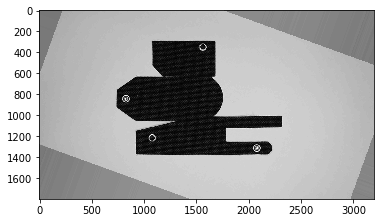

In [165]:
plt.imshow(deskew(img_g1), cmap = 'gray')